# Federated Learning

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from kernel import Kernel

from klms import *
from knlms import *
from krls import *
from klms_rff import *
from knlms_rff import *
from krls_rff import *

# Multiprocessing
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  8


In [18]:
import sys
sys.maxsize

9223372036854775807

In [2]:
def generate_data(num_data):
    # AWGN
    v = 0.1*np.random.normal(0,1,num_data+2) 

    # Initial conditions
    d_true =[0.1 , 0.1]
    d = [d_true[0] + v[0], d_true[1] + v[1]]

    # Grab new data
    new_d_true = lambda d: d.append((0.8 - 0.5 * np.exp(-(d[-1]**2)))*d[-1] - (0.3 + 0.9*np.exp(-(d[-1]**2)))*d[-2] + 0.1*np.sin(np.pi*d[-1]))
    for i in range(2,num_data+2):
        new_d_true(d_true)
        d.append(d_true[-1] + v[i])

    u = np.hstack((np.array(d[0:num_data]).reshape(num_data,1),np.array(d[1:num_data+1]).reshape(num_data,1)))
    d_true = d_true[2::]
    d = d[2::]
    return np.array(u), np.array(d),np.array(d_true)

# Parameters
num_data = 3000
kernel = Kernel(3.73)
K = 10 # K edge clients
step_size = 0.8
reg_coeff = 0.03
threshold = 0.5

100%|██████████████████████████████████| 10000/10000 [00:00<00:00, 32949.56it/s]


(0.01, 1.0)

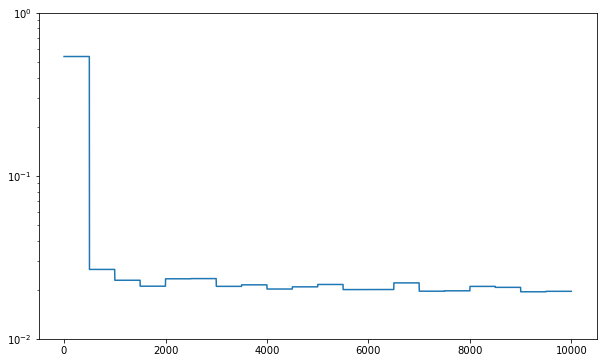

In [16]:
# Federated learning: Synchronous updating rule

l = 500 # l updates for synchronous
c =  np.ones(K).reshape(K,1)/K # edge weighting
D = 200 # Dictionary size

iteration = 10000
alpha_0 = np.zeros((D,1))
alphas = np.zeros((K,D))

final_mse = []

# Process data and kernel
u,d,d_true = generate_data(num_data)
mse = [np.var(d)]
sigma = 1/np.sqrt(2*kernel.sigma)
W = (1/sigma) * np.random.normal(loc=0, scale=sigma, size=(2,D))
b = np.random.uniform(0,2*np.pi,D).reshape(D,1)
h = np.sqrt(2/D) * np.cos(W.T @ u.T + b)
for n in tqdm(range(iteration)):

    # Local updates
    i = np.random.randint(0,num_data)
    edge = np.random.randint(0,K)

    alpha_k = alphas[edge].reshape((D,1))
    u_k = u[i]
    h_k = h[:,i].reshape((D,1))
    d_k = np.array([d[i]])
    err = d_k - h_k.T @ alpha_k
    alpha_step = alpha_k + step_size * err * h_k
#     _,alpha_step = KLMS_RFF(u_k,d_k,h_k,step_size,D,alpha_0=alpha_k)
    
    alphas[edge] = alpha_step.T

    # Global update
    if n % l == 0 and n > 1:
#         print(n)
        alpha = (alphas.T @ c)
        alphas = np.repeat(alpha,K,axis=1).T
        mse.append(np.square(np.linalg.norm(d[-500::].reshape(500,1) - h.T[-500::] @ alpha))/500)
    elif n > 1:
        mse.append(mse[-1])
# final_mse.append(mse[0])

plt.figure(figsize=(10, 6))
plt.semilogy(range(len(mse)),mse)
plt.ylim([1e-2,1e0])

In [21]:
alpha.dtype

dtype('float64')

In [7]:
# Federated learning: Asynchronous updating rule

In [ ]:
sigma = 1/np.sqrt(2*kernel.sigma)
W = (1/sigma) * np.random.normal(loc=0, scale=sigma, size=(2,D))
b = np.random.uniform(0,2*np.pi,D).reshape(D,1)
h = np.sqrt(2/D) * np.cos(W.T @ u.T + b)


In [18]:
np.random.randint(0,num_data)

1165

In [ ]:
u.shape

In [ ]:
W.T.shape

In [ ]:
b.shape